Task 1: Impact of Image Resolution on U-Net Segmentation Performance
Dataset: Kvasir-SEG (Polyp Segmentation)
Workflow: Original Image -> Scale to [512, 256, 128, 64] -> Rescale to 256x256 -> U-Net

This notebook investigates how different input resolutions affect segmentation quality.

Candidate 27 and Candidate 16.

# 1.0 Imports and Config

### 1.1 Imports and random seed

In [25]:
# Standard libraries
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

# Third-party libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # Added for Albumentations compatibility
import albumentations as A  # Added
from albumentations.pytorch import ToTensorV2  # Added

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
# REMOVED: import torchvision.transforms.functional as TF

# Custom local imports
from model import UNet
from utils import (
    DiceBCELoss,
    train_epoch,
    validate_epoch,
    EarlyStopping
)

SEED = 1337

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1.2 Configuration

In [ ]:
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    PREPROCESSED_PATH = "data\\kvasir-seg-preprocessed"
    
    # Experiment parameters
    RESOLUTIONS = [512, 256, 128, 64]
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 

    # LR Scheduler
    SCHEDULER_FACTOR = 0.1  # Use reduceLRonplateau
    SCHEDULER_PATIENCE = 3 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

### 1.3 Dataset Class

In [27]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=256, augmentation=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentation = augmentation
        self.target_size = target_size
        
        # Final transforms (always applied after augmentation)
        self.to_tensor_transform = A.Compose([
            A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)), # Scales [0, 255] -> [0, 1]
            ToTensorV2()
        ])

    def __len__(self):  
        return len(self.image_paths)
    
    def __getitem__(self, idx):  
        # Load pre-processed image and mask using PIL (to match Task 1's pre-processing)
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Convert PIL images to numpy arrays (required by Albumentations)
        image = np.array(image)
        mask = np.array(mask)

        # Binarize mask (0 or 255 -> 0 or 1)
        # Using > 128 is more robust for 0-255 images than > 0.5
        mask = (mask > 128).astype(np.uint8)
        
        # Apply Albumentations (if any)
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Apply final transforms (Normalize [0-1] + ToTensor)
        final_transform = self.to_tensor_transform(image=image, mask=mask)
        image_tensor = final_transform['image']
        mask_tensor = final_transform['mask']
        
        # Add channel dimension to mask (H, W) -> (1, H, W)
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

### 1.4 Path Collection and Validation

In [28]:
with open(train_file, 'r') as f:
    train_stems = {line.strip() for line in f}
with open(val_file, 'r') as f:
    val_stems = {line.strip() for line in f}

# Base path for preprocessed data
preprocessed_base = Path(config.PREPROCESSED_PATH)

# These dicts will hold the paths for each resolution
train_images_by_res = {}
train_masks_by_res = {}
val_images_by_res = {}
val_masks_by_res = {}

print("Collecting preprocessed file paths...")
# Collect paths for each resolution
for res in config.RESOLUTIONS:
    res_path = preprocessed_base / str(res)
    image_paths = sorted(list((res_path / config.IMAGE_DIR).glob('*.jpg')))
    mask_paths = sorted(list((res_path / config.MASK_DIR).glob('*.jpg')))

    if not image_paths or not mask_paths:
        print(f"WARNING: No preprocessed data found for resolution {res} in {res_path}")
        print("Please run the preprocess_images.py script first.")

    # Split dataset according to txt files
    train_images_by_res[res] = [p for p in image_paths if p.stem in train_stems]
    train_masks_by_res[res] = [p for p in mask_paths if p.stem in train_stems]
    val_images_by_res[res] = [p for p in image_paths if p.stem in val_stems]
    val_masks_by_res[res] = [p for p in mask_paths if p.stem in val_stems]

print(f"Train: {len(train_stems)} images, Val: {len(val_stems)} images (Preprocessed paths collected)")

Train: 700 images, Val: 300 images (Preprocessed paths collected)


# 2.0 Training and Results

### 2.1 Main Experiment Loop

In [29]:
# Store final results for each resolution
full_history_results = {}
experiment_results = {}

loss_fn = DiceBCELoss() # Define loss function (imported from utils.py)

# Loop over each resolution specified in the config
for res in config.RESOLUTIONS:

    # Set random seeds
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    print(f"\n{'='*50}")
    print(f"STARTING EXPERIMENT FOR RESOLUTION: {res}x{res}")
    print(f"{'='*50}")
    
    # 1. Create Datasets and DataLoaders
    # UPDATED to use the new Dataset constructor
    train_dataset = KvasirDataset(
        image_paths=train_images_by_res[res],
        mask_paths=train_masks_by_res[res],
        target_size=config.TARGET_SIZE,
        augmentation=None  # Use Albumentations workflow, but no augmentations
    )
    
    val_dataset = KvasirDataset(
        image_paths=val_images_by_res[res],
        mask_paths=val_masks_by_res[res],
        target_size=config.TARGET_SIZE,
        augmentation=None  # Validation dataset never has augmentations
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # 2. Initialize Model, Optimizer, Scheduler, and Early Stopping
    model = UNet(in_channels=config.IN_CHANNELS, 
                 out_channels=config.OUT_CHANNELS).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5) # CHANGED # Added weight decay to attempt to mitigate overfitting.
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=config.SCHEDULER_FACTOR,
        patience=config.SCHEDULER_PATIENCE,
        verbose=True # type: ignore
    )
    
    early_stopper = EarlyStopping(
        patience=config.EARLY_STOPPING_PATIENCE,
    )

    # 3. Training Loop
    verbose = True
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    for epoch in range(config.NUM_EPOCHS):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_dice, val_iou = validate_epoch(model, val_loader, loss_fn, device)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}.. "
                f"Train Loss: {train_loss:.4f}.. "
                f"Val Loss: {val_loss:.4f}.. "
                f"Val Dice: {val_dice:.4f}.. "
                f"Val IoU: {val_iou:.4f}")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        # Step the scheduler and early stopper on validation Dice
        scheduler.step(val_dice)
        early_stopper(val_dice, val_loss, val_iou, model)
        
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
            
    # 4. Save results for this resolution
    # We use the metrics from the best model (lowest val loss)
    print(f"Training finished for {res}x{res}.")
    
    # Get metrics from the best epoch saved by early_stopper
    final_loss = early_stopper.best_loss
    final_dice = early_stopper.best_score  # This is the best val_dice
    final_iou = early_stopper.best_iou

    print(f"Best Model Metrics for {res}x{res}: Val Loss: {final_loss:.4f}, Dice: {final_dice:.4f}, IoU: {final_iou:.4f}")

    experiment_results[res] = {
        'val_loss': final_loss,
        'dice': final_dice,
        'iou': final_iou
    }

    full_history_results[res] = history

print("\n--- All experiments finished! ---")


STARTING EXPERIMENT FOR RESOLUTION: 256x256
Epoch 5/25.. Train Loss: 0.3560.. Val Loss: 0.3730.. Val Dice: 0.6454.. Val IoU: 0.4832


KeyboardInterrupt: 

### 2.2 - Results (Plots)

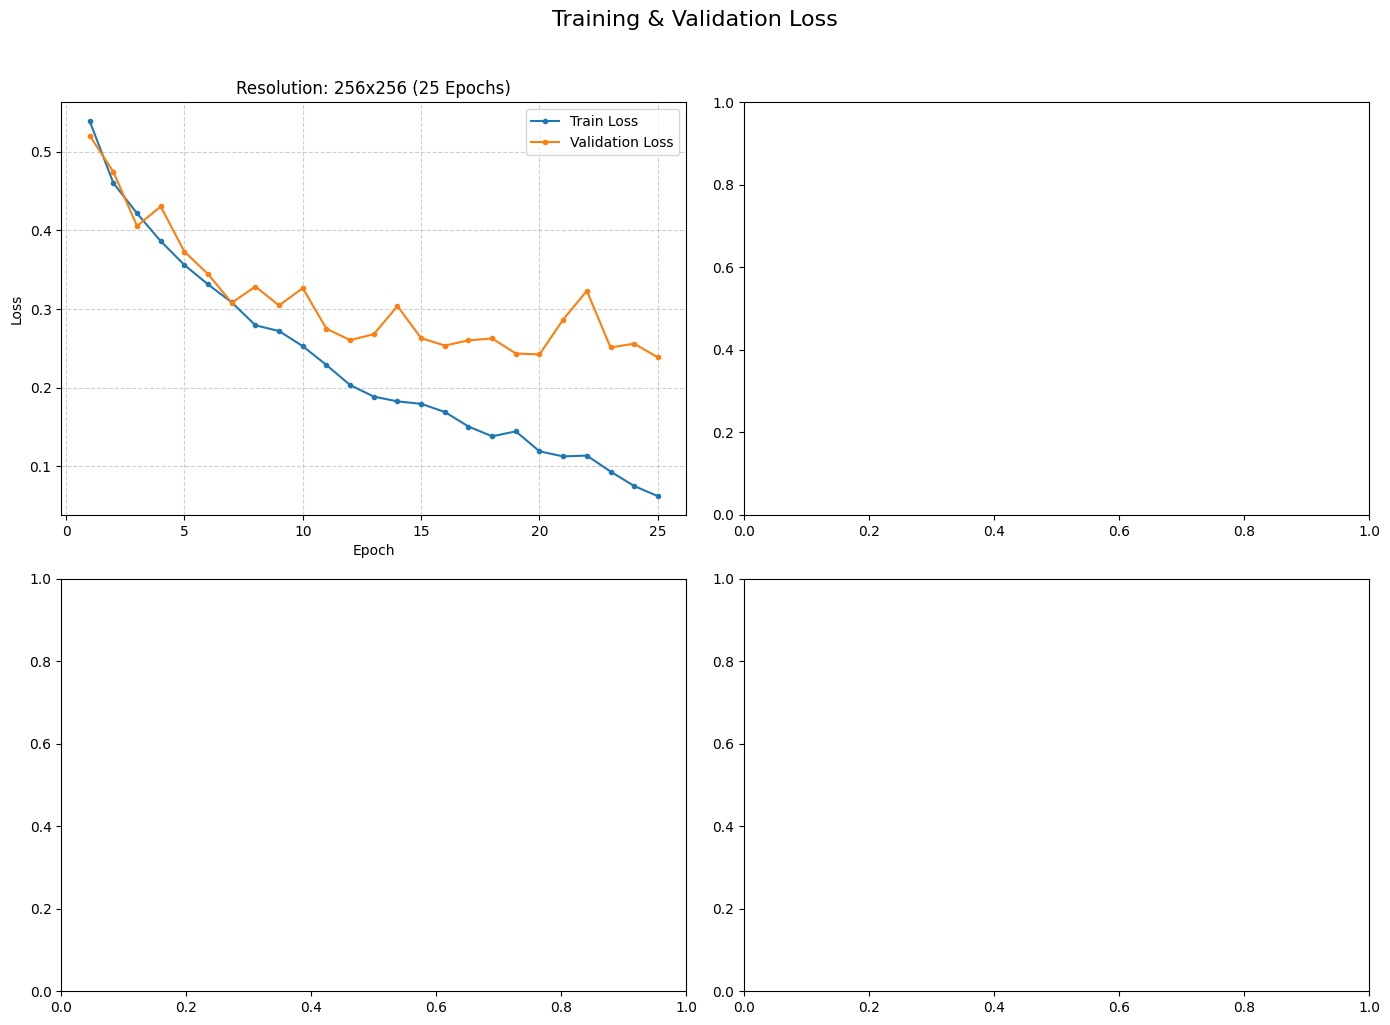

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Flatten the 2x2 grid into a 1D array for easy iteration
axes = axes.flatten()

resolutions_list = config.RESOLUTIONS

for i, res in enumerate(resolutions_list):
    if res in full_history_results:
        history = full_history_results[res]
        
        # Get number of epochs this resolution ran for
        epochs = len(history['train_loss'])
        epoch_range = range(1, epochs + 1)
        
        axes[i].plot(epoch_range, history['train_loss'], label='Train Loss', marker='.')
        axes[i].plot(epoch_range, history['val_loss'], label='Validation Loss', marker='.')
        axes[i].set_title(f'Resolution: {res}x{res} ({epochs} Epochs)')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f'Resolution: {res}x{res} (No data)')
        axes[i].axis('off')

fig.suptitle('Training & Validation Loss', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 2.3 Results (Bar Chart)


--- Final Experiment Results ---
            val_loss      dice       iou
Resolution                              
256         0.238636  0.782663  0.655357


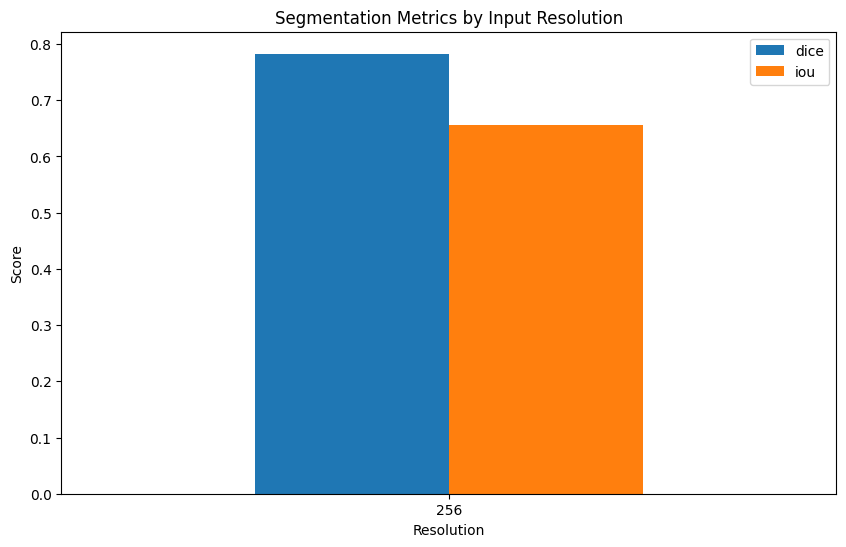

In [ ]:
# Convert results dictionary to a Pandas DataFrame
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.index.name = 'Resolution'
results_df = results_df.sort_index(ascending=False)

print("\n--- Final Experiment Results ---")
print(results_df)

# Plot the results
results_df.plot(kind='bar', y=['dice', 'iou'], 
                title='Segmentation Metrics by Input Resolution', 
                figsize=(10, 6))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()